### Linear regression example
A linear regression example, representing a relatively minimal example for how softcvi can be used.

### Imports

In [1]:
from typing import ClassVar

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from flowjax.distributions import Normal
from flowjax.experimental.numpyro import sample
from flowjax.train import fit_to_variational_target
from jaxtyping import Array, PRNGKeyArray

from softcvi.losses import SoftContrastiveEstimationLoss
from softcvi.models import AbstractGuide, AbstractModel


### Define the model

In [2]:

class RegressionModel(AbstractModel):
    observed_names = {"y"}
    reparameterized: bool
    reparam_names = set()
    sigma: float | int
    n_covariates: ClassVar[int] = 50
    n_obs: ClassVar[int] = 200
    x: Array

    def __init__(self, key: PRNGKeyArray):
        self.x = jr.normal(key, (self.n_obs, self.n_covariates))  # Generate toy data
        self.reparameterized = False
        self.sigma = 1

    def call_without_reparam(
        self,
        obs: dict[str, Array] | None = None,
    ):
        obs = obs["y"] if obs is not None else None

        beta = sample("beta", Normal(jnp.zeros(self.n_covariates)))
        bias = sample("bias", Normal())
        mu = self.x @ beta + bias
        sample("y", Normal(mu, self.sigma), obs=obs)


class RegressionGuide(AbstractGuide):
    beta: Normal
    bias: Normal

    def __init__(self):
        self.beta = Normal(jnp.zeros(RegressionModel.n_covariates))
        self.bias = Normal()

    def __call__(self):
        sample("beta", self.beta)
        sample("bias", self.bias)

key, subkey = jr.split(jr.PRNGKey(0))
model = RegressionModel(subkey)
guide = RegressionGuide()


### Generate toy data

In [3]:
key, subkey = jr.split(key)
latents = model.sample(subkey)
obs = {"y": latents.pop("y")}

### Fit posterior

In [4]:

loss = SoftContrastiveEstimationLoss(
    model=model,
    n_particles=4,
    obs=obs,
    alpha=0.75,
    )

key, subkey=jr.split(key)
guide, losses = fit_to_variational_target(
    key=subkey,
    dist=guide,
    loss_fn=loss,
    steps=20000,
    learning_rate=1e-2,
)

100%|██████████| 20000/20000 [01:25<00:00, 232.65it/s, loss=0.596] 


Text(0, 0.5, '$\\beta$ posterior mean')

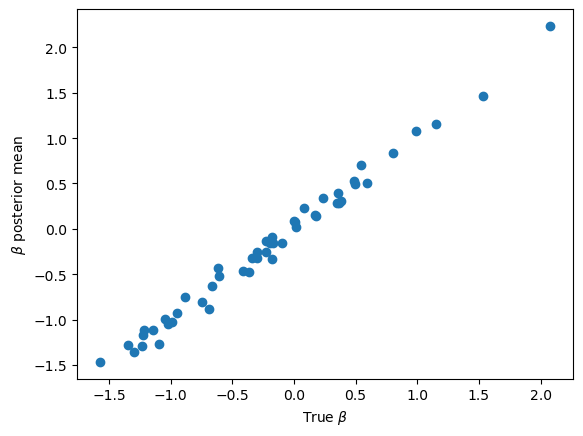

In [5]:
# Plot true coefficients against posterior means
plt.scatter(latents["beta"], guide.beta.loc)
plt.xlabel(r"True $\beta$")
plt.ylabel(r"$\beta$ posterior mean")
